# Decision Trees on Heart Disease Dataset

During this experiment, we will investigate and implement Decision Trees, Random Forests, and AdaBoost using scikit-learn.
We will use scikit-learn's built-in tools to visualize decision trees for predicting heart diseases.

## Dataset

The models will be trained using the [Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease).
Fourteen features were selected among 76 attributes:
1. age: age in years
2. sex: (1 = male; 0 = female)
3. cp: chest pain type (Value 0: asymptomatic, Value 1: atypical angina, Value 2: non-anginal pain, Value 3: typical angina -- *Note: Original dataset values 1-4, mapped here for consistency with prior notebook logic*)
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. restecg: resting electrocardiographic results (Value 0: showing probable or definite left ventricular hypertrophy by Estes' criteria, Value 1: normal, Value 2: having ST-T wave abnormality)
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: (Value 0: unknown/imputed, Value 3: fixed defect, Value 6: normal, Value 7: reversable defect -- *Note: UCI docs differ slightly; 3=normal, 6=fixed, 7=reversible. Sticking to prior notebook's value interpretation for imputation consistency.*)
14. disease: (0 = no disease, 1 = disease)

In [9]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree # Ensure plot_tree is imported
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from IPython.display import display # To display DataFrames nicely

### Read CSV using Pandas

In [10]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

--2025-05-31 16:23:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘processed.cleveland.data’

processed.cleveland     [ <=>                ]  18.03K  --.-KB/s    in 0.03s   

2025-05-31 16:23:58 (686 KB/s) - ‘processed.cleveland.data’ saved [18461]



In [11]:
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'disease'
]

file_path = os.path.join('processed.cleveland.data')
hdisease = None # Initialize hdisease

if not os.path.exists('data'):
    os.makedirs('data')
    print("Created 'data' directory. Please download 'processed.cleveland.data' into it.")
    print("E.g., from: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
elif not os.path.exists(file_path):
    print(f"'{file_path}' not found. Please download it into the 'data' directory.")
    print("E.g., from: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
else:
    hdisease = pd.read_csv(file_path, header=None, names=column_names, na_values='?')
    print("Data loaded successfully.")

Data loaded successfully.


### Replacing Missing Values & Data Type Conversion

In [12]:
if hdisease is not None:
    # Target variable: 0 for no disease, 1 for presence of disease
    hdisease['disease'] = np.where(hdisease['disease'] > 0, 1, 0)

    # Impute missing 'ca' with 4.0 (as a new category, per original notebook logic)
    hdisease['ca'].fillna(4.0, inplace=True)

    # Impute missing 'thal' with 0.0 (as a new category, per original notebook logic)
    hdisease['thal'].fillna(0.0, inplace=True)

    # Ensure all columns are numeric. Coerce errors will turn problematic values to NaN.
    for col in hdisease.columns:
        hdisease[col] = pd.to_numeric(hdisease[col], errors='coerce')

    if hdisease.isnull().sum().sum() > 0:
        print("Warning: NaNs found after initial processing. Imputing remaining NaNs with column medians.")
        for col in hdisease.columns:
            if hdisease[col].isnull().any():
                hdisease[col].fillna(hdisease[col].median(), inplace=True)

    print("\nCleaned DataFrame head:")
    display(hdisease.head())
    print("\nDataFrame Info:")
    hdisease.info()
    print("\nMissing values after cleaning:")
    print(hdisease.isnull().sum())
else:
    print("DataFrame 'hdisease' not loaded. Skipping preprocessing.")


Cleaned DataFrame head:


<ipython-input-12-1d637798153f>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hdisease['ca'].fillna(4.0, inplace=True)
<ipython-input-12-1d637798153f>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    float64
 12  thal      303 non-null    float64
 13  disease   303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB

Missing values after cleaning:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
th

### Correlation Heatmap

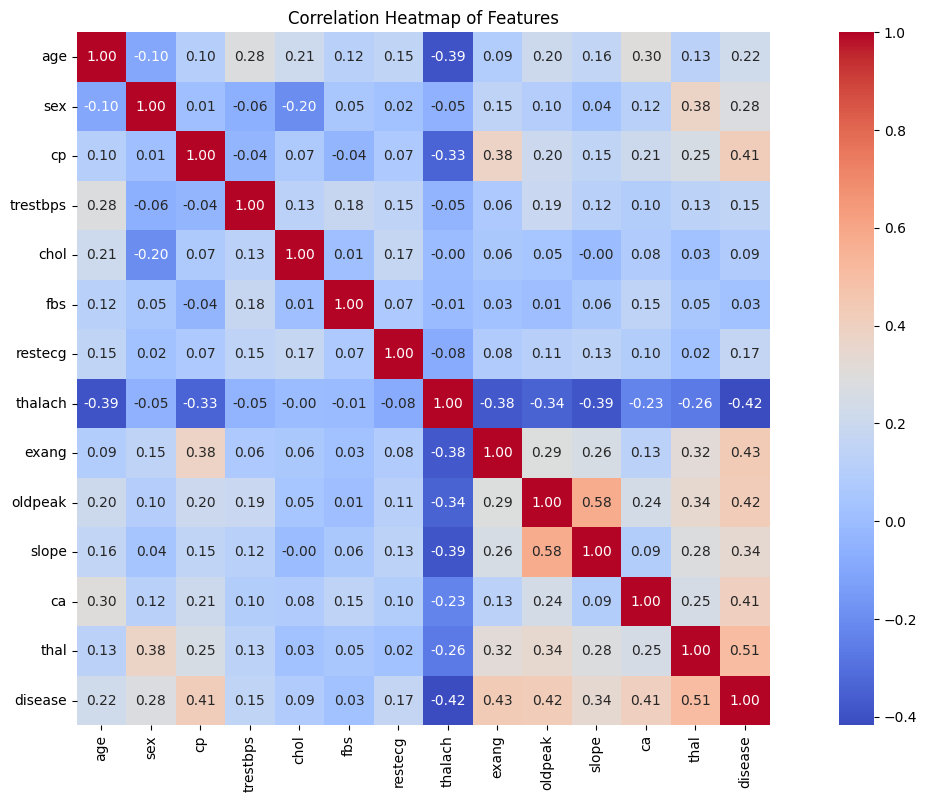

In [13]:
if hdisease is not None:
    plt.figure(figsize=(18, 9)) # Adjusted size for better readability
    sns.heatmap(hdisease.corr(), annot=True, square=True, fmt='0.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Features')
    plt.show()

### Barplots for EDA

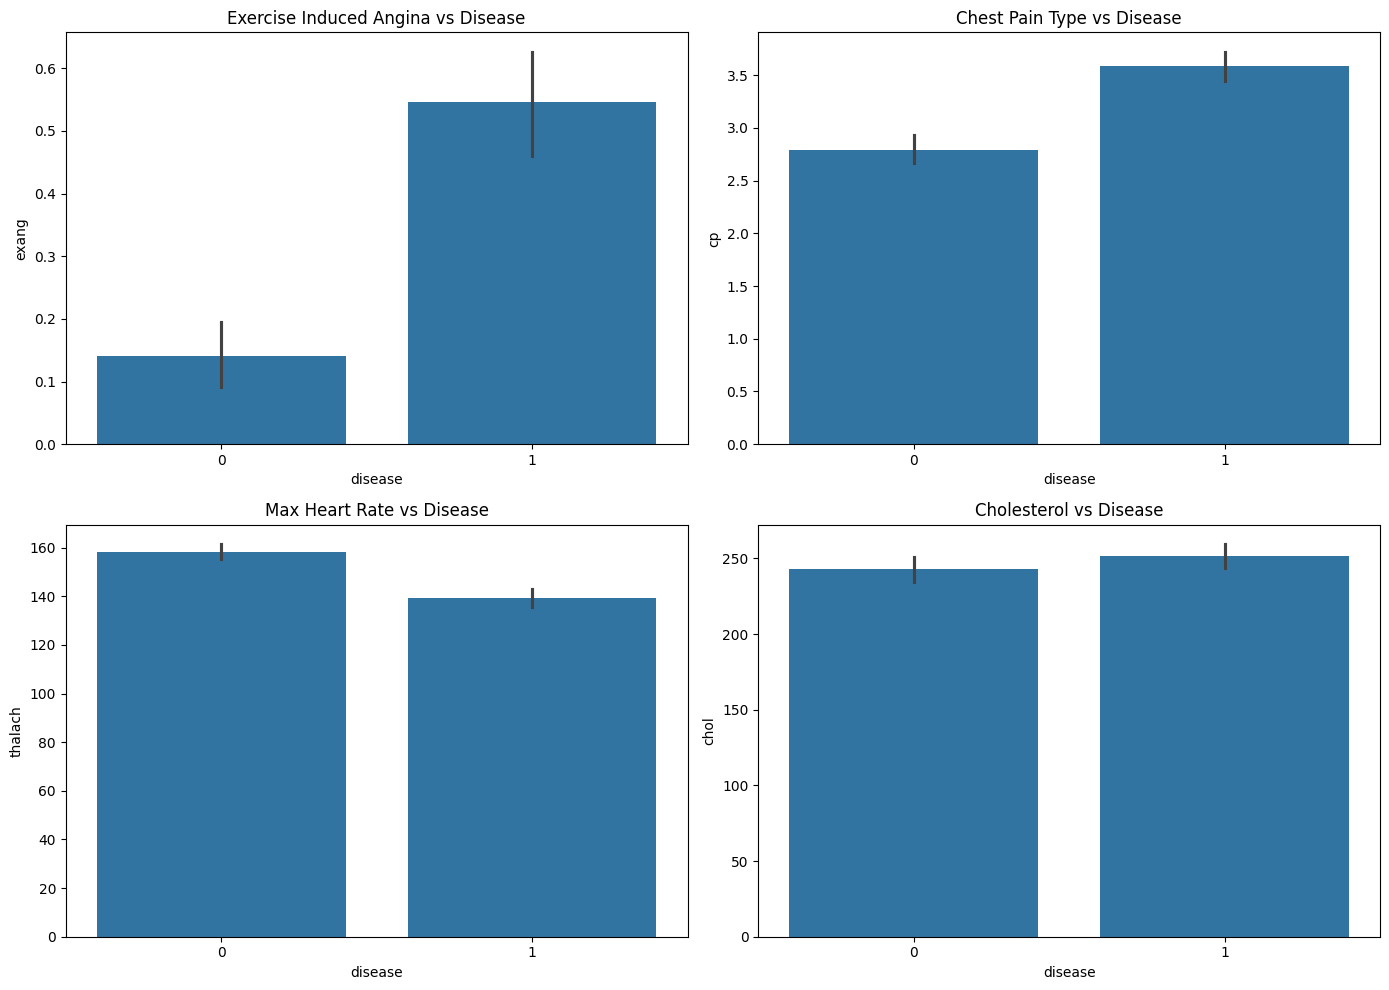

In [14]:
if hdisease is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10)) # Adjusted size
    sns.barplot(x='disease', y='exang', data=hdisease, ax=axes[0, 0])
    axes[0,0].set_title('Exercise Induced Angina vs Disease')

    sns.barplot(x='disease', y='cp', data=hdisease, ax=axes[0, 1])
    axes[0,1].set_title('Chest Pain Type vs Disease')

    sns.barplot(x='disease', y='thalach', data=hdisease, ax=axes[1, 0])
    axes[1,0].set_title('Max Heart Rate vs Disease')

    sns.barplot(x='disease', y='chol', data=hdisease, ax=axes[1, 1])
    axes[1,1].set_title('Cholesterol vs Disease')

    plt.tight_layout()
    plt.show()

**Observations from EDA:**
Many features exhibit some correlation with the target variable ('disease'). The bar plots suggest that patients with heart disease are more likely to have:
- Higher values for 'cp' (chest pain type, depending on specific mapping).
- Lower 'thalach' (maximum heart rate achieved).
- Presence of 'exang' (exercise-induced angina, exang=1).
Cholesterol levels ('chol') don't show a strong direct difference between the two groups in these simple plots.

### Decision Trees Theory
Decision trees partition the input space into regions, making decisions at each node based on feature values. The goal is to create pure leaves (nodes where all samples belong to one class).
The Gini impurity is a common criterion for evaluating splits:
For a leaf with $N$ samples, and class-conditional probability $\hat{\pi}_c = \frac{1}{N} \sum_{i \in D}\mathbb{I}(y_i = c)$, the Gini impurity is:
$$ G_{leaf} = 1 - \sum_{c=1}^{C}\hat{\pi}^2_c $$
For a split, the weighted average Gini impurity of child nodes is used:
$$ G_{node} = \sum_{j=1}^{K} \frac{N_j}{N_{parent}}G_{leaf_j} $$
The algorithm selects splits that maximize the reduction in Gini impurity.


Sklearn Decision Tree Visualization (plot_tree):


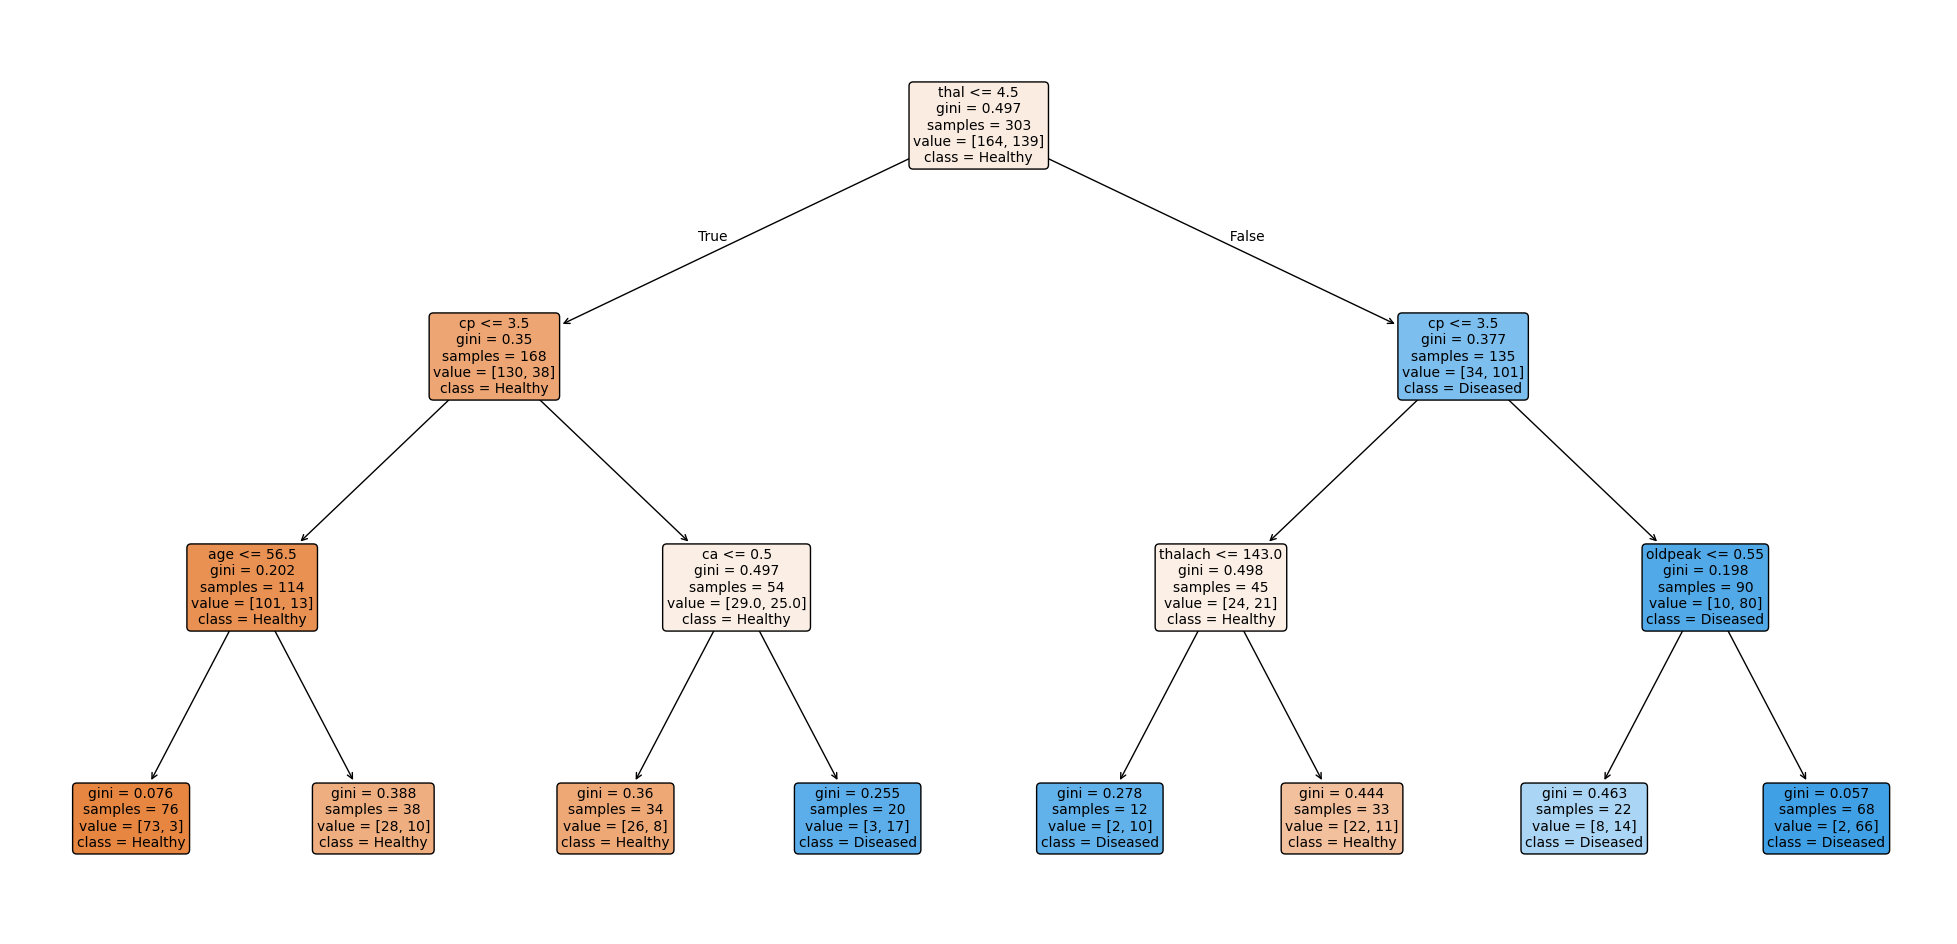


Sklearn Decision Tree Cross-Validation Accuracy: 0.7884 (Std: +/- 0.0701)


In [24]:
if hdisease is not None:
    X = hdisease.drop('disease', axis=1)
    y = hdisease['disease']

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    target_class_names = ['Healthy', 'Diseased']

    # X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    # Decision Tree Classifier with sklearn
    dt_sklearn = DecisionTreeClassifier(max_depth=3, random_state=42)
    dt_sklearn.fit(X, y)

    # Visualize with sklearn.tree.plot_tree
    plt.figure(figsize=(25,12)) # Increased figure size for plot_tree
    plot_tree(dt_sklearn,
              feature_names=X.columns.tolist(),
              class_names=target_class_names,
              filled=True,
              rounded=True,
              fontsize=10)
    plt.title("Decision Tree Visualization")
    plt.show()

    # Cross Validation
    dt_cv_scores = cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=42),
                                   X, y_encoded, scoring='accuracy', cv=5)
    print(f"\nSklearn Decision Tree Cross-Validation Accuracy: {dt_cv_scores.mean():.4f} (Std: +/- {dt_cv_scores.std():.4f})")

    # Performance on Test Set
    # y_pred_dt = dt_sklearn.predict(X_test)
    # print("\nSklearn Decision Tree Performance on Test Set:")
    # print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
    # print(classification_report(y_test, y_pred_dt, target_names=target_class_names))
else:
    print("DataFrame 'hdisease' not loaded. Skipping Decision Tree modeling.")

The Decision Tree achieves a cross-validated accuracy in the range of 78-81%. The `plot_tree` visualization helps in understanding the feature importance and decision rules. Key features like 'thal', 'ca', and 'cp' often appear at the top of the tree.

### Random Forest Theory
Random Forest is an ensemble learning method that constructs multiple decision trees during training. For classification, the output is the class selected by most trees. It uses bootstrapping (random sampling with replacement) for training data for each tree and considers a random subset of features for splitting at each node, leading to decorrelated trees and reduced variance.

In [16]:
if hdisease is not None:
    print("\n--- Random Forest Classifier ---")
    param_grid_rf = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 5, 7, None],
        'max_features': ['sqrt', 'log2', 0.6]
    }

    rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'),
                           param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    rf_grid.fit(X_train, y_train)

    print(f"\nBest Random Forest Parameters: {rf_grid.best_params_}")
    print(f"Best CV Accuracy for Random Forest: {rf_grid.best_score_:.4f}")

    best_rf = rf_grid.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    print("\nRandom Forest Performance on Test Set (with best params):")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    print(classification_report(y_test, y_pred_rf, target_names=target_class_names))
else:
    print("DataFrame 'hdisease' not loaded. Skipping Random Forest modeling.")


--- Random Forest Classifier ---
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Random Forest Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Best CV Accuracy for Random Forest: 0.8304

Random Forest Performance on Test Set (with best params):
Accuracy: 0.8689
              precision    recall  f1-score   support

     Healthy       0.90      0.85      0.88        33
    Diseased       0.83      0.89      0.86        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



Random Forest typically improves accuracy over a single Decision Tree by reducing overfitting. `GridSearchCV` helps find optimal hyperparameters, often leading to accuracies in the low to mid-80s percentile for this dataset.

### AdaBoost Theory
AdaBoost (Adaptive Boosting) is an ensemble technique that combines multiple weak learners (typically decision stumps - trees with only one split) sequentially. Each subsequent learner gives more weight to instances misclassified by previous learners. The final prediction is a weighted vote of all learners, where more accurate learners receive higher weights.


--- AdaBoost Classifier ---

Iterating n_estimators for AdaBoost (CV scores):


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

AdaBoost (Stumps) CV Accuracy: 0.8150 (Std: +/- 0.0418), n_estimators: 20


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost (Stumps) CV Accuracy: 0.8183 (Std: +/- 0.0487), n_estimators: 40


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

AdaBoost (Stumps) CV Accuracy: 0.8215 (Std: +/- 0.0394), n_estimators: 60


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

AdaBoost (Stumps) CV Accuracy: 0.8116 (Std: +/- 0.0321), n_estimators: 80


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost (Stumps) CV Accuracy: 0.8149 (Std: +/- 0.0398), n_estimators: 100


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

AdaBoost (Stumps) CV Accuracy: 0.7886 (Std: +/- 0.0260), n_estimators: 120


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

AdaBoost (Stumps) CV Accuracy: 0.8017 (Std: +/- 0.0391), n_estimators: 140


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

AdaBoost (Stumps) CV Accuracy: 0.8115 (Std: +/- 0.0442), n_estimators: 160


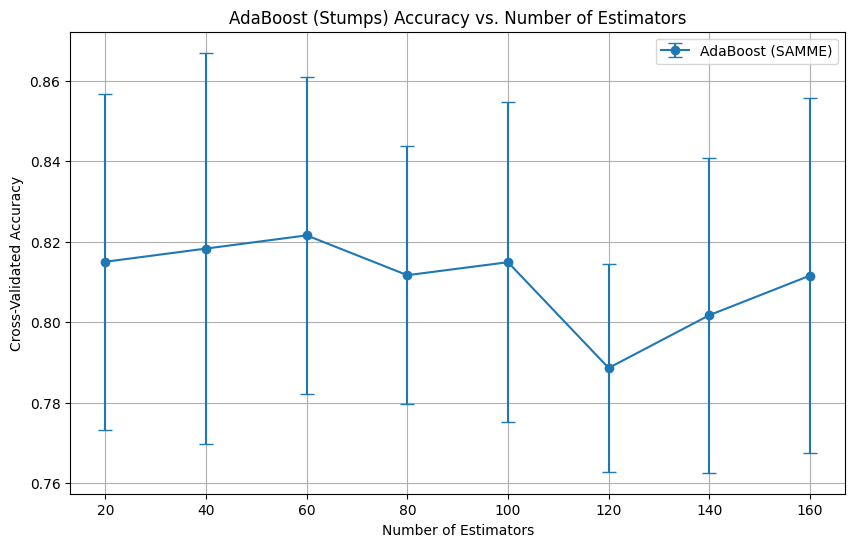


Running GridSearchCV for AdaBoost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Best AdaBoost Parameters: {'estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 100}
Best CV Accuracy for AdaBoost: 0.8388

AdaBoost Performance on Test Set (with best params):
Accuracy: 0.8689
              precision    recall  f1-score   support

     Healthy       0.93      0.82      0.87        33
    Diseased       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



In [17]:
if hdisease is not None:
    print("\n--- AdaBoost Classifier ---")

    # Iterating through n_estimators for demonstration
    print("\nIterating n_estimators for AdaBoost (CV scores):")
    n_estimators_range_ada = range(20, 161, 20)
    ada_cv_means_iter = []
    ada_cv_stds_iter = []

    for n_est in n_estimators_range_ada:
        ada_iter = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42), # Explicitly using stumps
                                    n_estimators=n_est, random_state=42, algorithm='SAMME') # Changed algorithm to 'SAMME'
        cv_acc_ada_iter = cross_val_score(ada_iter, X, y_encoded, scoring='accuracy', cv=5)
        mean_cv_acc_iter = cv_acc_ada_iter.mean()
        std_cv_acc_iter = cv_acc_ada_iter.std()
        ada_cv_means_iter.append(mean_cv_acc_iter)
        ada_cv_stds_iter.append(std_cv_acc_iter)
        print(f'AdaBoost (Stumps) CV Accuracy: {mean_cv_acc_iter:.4f} (Std: +/- {std_cv_acc_iter:.4f}), n_estimators: {n_est}')

    plt.figure(figsize=(10, 6))
    plt.errorbar(list(n_estimators_range_ada), ada_cv_means_iter, yerr=ada_cv_stds_iter, marker='o', capsize=5, label='AdaBoost (SAMME)')
    plt.title('AdaBoost (Stumps) Accuracy vs. Number of Estimators')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Cross-Validated Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

    # GridSearchCV for AdaBoost
    print("\nRunning GridSearchCV for AdaBoost...")
    param_grid_ada = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.5, 1.0],
        'estimator__max_depth': [1, 2] # Tuning base estimator's depth
    }
    # Ensure the base estimator passed to AdaBoost for GridSearchCV is a new instance
    ada_base_estimator = DecisionTreeClassifier(random_state=42)
    ada_grid = GridSearchCV(AdaBoostClassifier(estimator=ada_base_estimator, random_state=42, algorithm='SAMME'), # Changed algorithm to 'SAMME'
                          param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    ada_grid.fit(X_train, y_train)

    print(f"\nBest AdaBoost Parameters: {ada_grid.best_params_}")
    print(f"Best CV Accuracy for AdaBoost: {ada_grid.best_score_:.4f}")

    best_ada = ada_grid.best_estimator_
    y_pred_ada = best_ada.predict(X_test)
    print("\nAdaBoost Performance on Test Set (with best params):")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_ada):.4f}")
    print(classification_report(y_test, y_pred_ada, target_names=target_class_names))
else:
    print("DataFrame 'hdisease' not loaded. Skipping AdaBoost modeling.")

AdaBoost, especially when tuned, can provide competitive performance, often similar to Random Forest for this dataset. The choice of base estimator (e.g., decision stumps vs. slightly deeper trees) and the learning rate are important tuning parameters.

### Overall Conclusion
This notebook demonstrated the application of Decision Trees, Random Forests, and AdaBoost classifiers to the Heart Disease dataset using `scikit-learn`.

1.  **Data Preprocessing**: Essential for handling missing values and ensuring correct data types.
2.  **EDA**: Revealed correlations and feature distributions helpful for understanding potential predictors.
3.  **Decision Tree**: Provided a baseline performance and an interpretable model, visualized using `sklearn.tree.plot_tree`.
4.  **Random Forest**: Showed improved performance over a single Decision Tree by leveraging an ensemble of trees, with hyperparameter tuning via `GridSearchCV` further optimizing results.
5.  **AdaBoost**: Another ensemble method that offered competitive performance, demonstrating the power of boosting weak learners.

Ensemble methods (Random Forest and AdaBoost) generally outperformed the single Decision Tree, highlighting their effectiveness in improving predictive accuracy and robustness. Hyperparameter tuning proved crucial for extracting the best performance from these models.